In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def smooth(x,window_len=11,window='hanning'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError( "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [33]:
df = pd.read_csv('./Labs/muon_271119/Run0/ch2_values.csv', header=None)


In [62]:
temp = df.values
raw_data = temp[18].flatten()
raw_data *= -1.0

In [63]:
smoothed_data = smooth(raw_data, window_len=51, window='bartlett')
timesteps = np.arange(0,1000,1)
data = np.concatenate((smoothed_data[0:1000,np.newaxis], timesteps[:,np.newaxis]), axis=1)

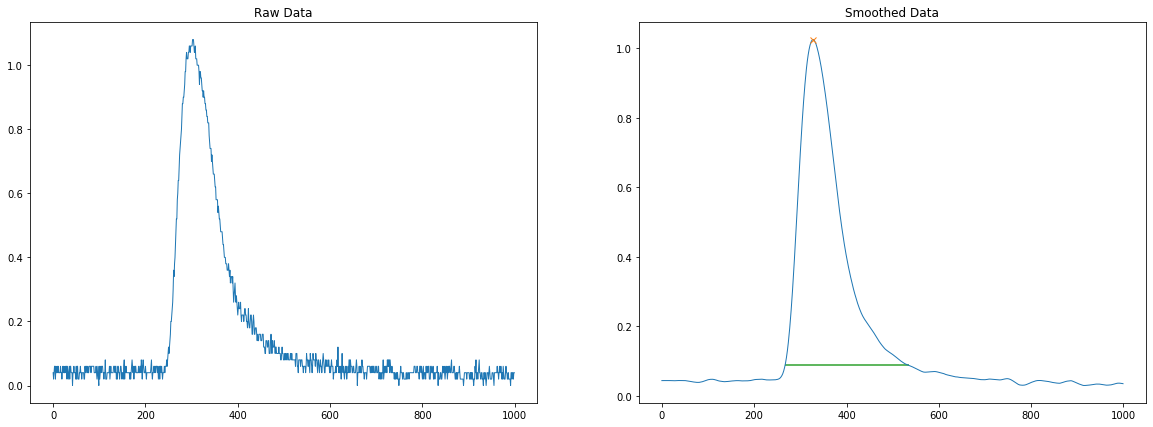

In [64]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(timesteps, raw_data, '-', lw=1)
plt.title("Raw Data")
plt.subplot(122)
peaks, properties = signal.find_peaks(data[:,0], height=0.2*data[:,0].max())
results_w = signal.peak_widths(data[:,0], peaks, rel_height=0.95)
plt.plot(data[:,1], data[:,0],'-', lw=1)
plt.plot(peaks, data[:,0][peaks], "x")
plt.hlines(*results_w[1:], color="C2")
plt.title("Smoothed Data")
plt.show()

In [65]:
print('Peaks width: {wd}'.format(wd = results_w[1:][0] ))
for i in range(results_w[1:][0].size):
    print('Found peak in range: {rr1}, {rr2}'.format(rr1 = results_w[1:][i+1],rr2 = results_w[1:][i+2]))
print("Found peak at index {t} with amplitude: {amp}".format(t=peaks,amp=smoothed_data[peaks]))

Peaks width: [0.0882352]
Found peak in range: [266.91282723], [534.36944444]
Found peak at index [328] with amplitude: [1.024768]


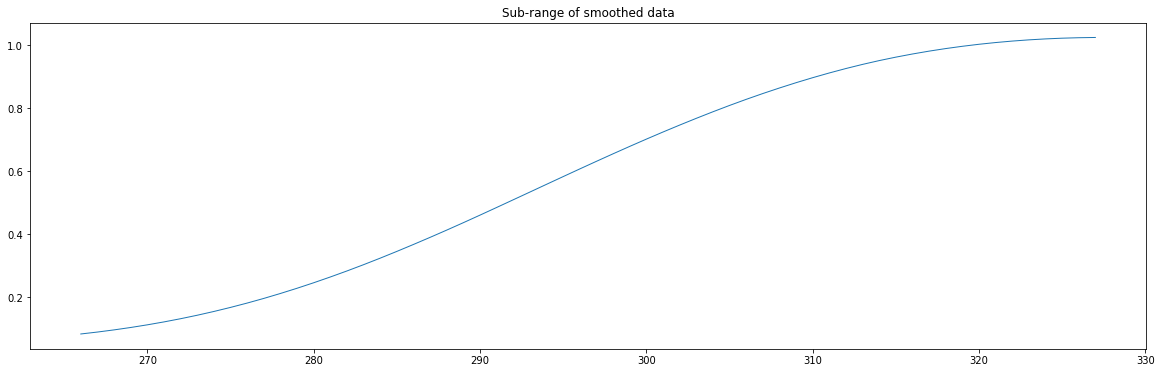

In [66]:
# ranged_sm_data = smoothed_data[smoothed_data>=0.024*smoothed_data[peaks].max()]
# ranged_sm_data = smoothed_data[0:peaks[0]]
# ranged_sm_data = ranged_sm_data[ranged_sm_data>=0.03*smoothed_data[peaks].max()]
a = int(results_w[1:][1])
# ranged_sm_data = data[0:peaks[0]]
# ranged_sm_data = ranged_sm_data[ranged_sm_data[:,0] >= 0.05 * data[peaks,0].max()]
ranged_sm_data = data[a:peaks[0]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,1], ranged_sm_data[:,0],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

In [9]:
from iminuit import Minuit

In [10]:
def gauss(mu, sig):
#     A, mu, sigma = p
    return np.exp(-(ranged_sm_data[:,1]-mu)**2/(2.*sig**2))


def negLogL(mu, sig):
    pdf = gauss(ranged_sm_data[:,1], mu=mu, sig=sig )
    if np.any(np.isnan(pdf)) or np.any(pdf <= 0):
        return 9e99 # Minuit doesn't like np.nan
    return -np.sum(np.log(pdf))

In [11]:
params = {'mu':500, 'sig':5}            
# m = Minuit(negLogL, errordef=0.5, **params)
m = Minuit(gauss)
# minuit.get_param_states()

/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: Parameter mu does not have initial value. Assume 0.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: Parameter sig does not have initial value. Assume 0.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: InitialParamWarning: Parameter sig is floating but does not have initial step size. Assume 1.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/john/miniconda3/lib/python3.7/si

In [12]:
m.migrad()

/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


RuntimeError: cannot convert call result to double
User function arguments:
     mu = +0.000000
    sig = +0.000000
Original python exception in user function:
TypeError: only size-1 arrays can be converted to Python scalars


In [38]:
int(results_w[1:][1])

TypeError: only size-1 arrays can be converted to Python scalars

In [0]:
plt.plot(ranged_sm_data[:,1],gauss(ranged_sm_data[:,1],500,20))

In [69]:
results_w[2:][0][0]


266.9128272251309